In [1]:
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

In [2]:
import numpy as np
import os # Operating system
import re #Regular Expression
import gensim
import multiprocessing
from nltk.tokenize import word_tokenize,WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from string import digits
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from xgboost import XGBClassifier
import string
from string import punctuation
from nltk.corpus import stopwords
import nltk.corpus.util
from sklearn.tree import DecisionTreeClassifier
from nltk.classify import NaiveBayesClassifier
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
import matplotlib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [3]:
cores = multiprocessing.cpu_count() - 1
cores

7

## Data Load

In [10]:
#add consumer data here
df1 = pd.read_csv(r'Commerical Relabeld data_FINAL.csv',encoding = 'latin1')
df1.head()
df1.shape

(4752, 5)

In [11]:
df1.columns

Index(['Verbatim', 'CustomerSentiment(New)', 'Sat_Metric_OverallQoSBox',
       'IsResolved', 'VerbatimLength'],
      dtype='object')

In [12]:
# changing index cols with rename() 
df1.rename(columns = {"ï»¿Verbatim": "Verbatim","CustomerSentiment(New)": "Sentiments"},
                    inplace = True) 
df1.head(2)

,Verbatim,Sentiments,Sat_Metric_OverallQoSBox,IsResolved,VerbatimLength
0,"$5,000 Azure credit for non profit has not bee...",Negative,BB,No,202
1,(1) Quick response to submitted request(2) Kno...,Positive,TB,Yes,113


In [13]:
print(df1.columns)
#Length of Dataframe
print(len(df1))
#Rows not containing any text data
print(len(df1[df1["Verbatim"].isna() == True]))#0 null values

Index(['Verbatim', 'Sentiments', 'Sat_Metric_OverallQoSBox', 'IsResolved',
       'VerbatimLength'],
      dtype='object')
4752
0


In [14]:
df2=df1[['IsResolved', 'Sat_Metric_OverallQoSBox','VerbatimLength']]

## Exploratory Data Analysis

<AxesSubplot:>

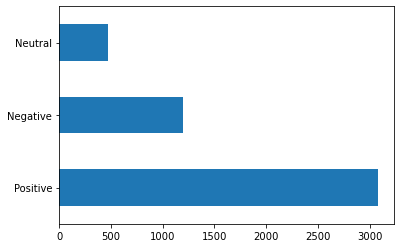

In [15]:
df1['Sentiments'].value_counts().plot(kind='barh')

In [16]:
#Getting percentage for various classes in a column
df1.Sentiments.value_counts()

Positive    3079
Negative    1198
Neutral      475
Name: Sentiments, dtype: int64

# Data Preprocessing 

In [17]:
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
tokenizer = RegexpTokenizer(r'\w+')
def clean_sentences(text):
    #Input: Sentences
    #Output: cleaned sentence by removing numbers, stopwords, punctuations, single alphabet, and change single uppercase to lowercase letters
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)    
    text = tokenizer.tokenize(text)
    text = [s.lower() for s in text]
    #text = [s for s in text if s not in set(stopwords.words('english'))]
    text = [s for s in text if len(s)>1]
    #text = ' '.join(text)
    return text   
 

In [18]:
df1['cleaned_test'] =df1['Verbatim'].apply(lambda x: clean_sentences(x))

In [19]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['support','microsoft','problem','issue','service','namepii']
stopwords.extend(newStopWords) #Joining stopwords and newstopwords

#Removing stopwords from tokens
df1["cleaned_test"] = df1["cleaned_test"].apply(lambda row :[item for item in row if item not in stopwords])


In [20]:
#Join for wordnet lemmatization
df1['cleaned_test']  = df1['cleaned_test'].apply(' '.join)
df1.head(2)


,Verbatim,Sentiments,Sat_Metric_OverallQoSBox,IsResolved,VerbatimLength,cleaned_test
0,"$5,000 Azure credit for non profit has not bee...",Negative,BB,No,202,azure credit non profit applied new azure acco...
1,(1) Quick response to submitted request(2) Kno...,Positive,TB,Yes,113,quick response submitted request knowledgeable...


In [21]:
data_dum=pd.get_dummies(df2, dummy_na=False)
data_dum.head(2)

,VerbatimLength,IsResolved_No,IsResolved_UNKNOWN,IsResolved_Yes,Sat_Metric_OverallQoSBox_BB,Sat_Metric_OverallQoSBox_MB,Sat_Metric_OverallQoSBox_TB,Sat_Metric_OverallQoSBox_UNKNOWN
0,202,1,0,0,1,0,0,0
1,113,0,0,1,0,0,1,0


In [22]:
df_f = pd.concat([data_dum.reset_index(drop=True), df1[['Sentiments','cleaned_test']]], axis=1)
df_f.head(2)

,VerbatimLength,IsResolved_No,IsResolved_UNKNOWN,IsResolved_Yes,Sat_Metric_OverallQoSBox_BB,Sat_Metric_OverallQoSBox_MB,Sat_Metric_OverallQoSBox_TB,Sat_Metric_OverallQoSBox_UNKNOWN,Sentiments,cleaned_test
0,202,1,0,0,1,0,0,0,Negative,azure credit non profit applied new azure acco...
1,113,0,0,1,0,0,1,0,Positive,quick response submitted request knowledgeable...


In [23]:
df_f.Sentiments.value_counts(normalize=True)

Positive    0.647938
Negative    0.252104
Neutral     0.099958
Name: Sentiments, dtype: float64

In [24]:
y = df_f.Sentiments

In [25]:
#df_f=df_f.drop(['Sentiments'],axis=1)



In [26]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df_f, y, test_size=0.30,random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
X_train.head(2)

(3326, 10) (3326,)
(1426, 10) (1426,)


,VerbatimLength,IsResolved_No,IsResolved_UNKNOWN,IsResolved_Yes,Sat_Metric_OverallQoSBox_BB,Sat_Metric_OverallQoSBox_MB,Sat_Metric_OverallQoSBox_TB,Sat_Metric_OverallQoSBox_UNKNOWN,Sentiments,cleaned_test
3880,240,0,0,1,0,1,0,0,Negative,timeline resolution time around long spanned w...
1188,56,0,0,1,0,1,0,0,Neutral,helpful got past misunderstandings


In [27]:
#% distribution on Pos/neg/neu in full sample data
X_train.Sentiments.value_counts()

Positive    2151
Negative     828
Neutral      347
Name: Sentiments, dtype: int64

In [28]:
# % distribution on pos/neg/neu after oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


In [29]:
oversample=RandomOverSampler(sampling_strategy={'Positive':2152,'Negative':900,'Neutral':600})

In [30]:
X_train,y_train=oversample.fit_resample(X_train,y_train)

In [31]:
print(X_train.shape,y_train.shape)

(3652, 10) (3652,)


In [32]:
X_train.Sentiments.value_counts(normalize=True)

Positive    0.589266
Negative    0.246440
Neutral     0.164294
Name: Sentiments, dtype: float64

In [33]:
#oversamplesmote=SMOTE()

In [34]:
#X_train,y_train=oversample.fit_resample(X_train,y_train)

In [35]:
#print(X_train.shape,y_train.shape)

In [36]:
X_train.Sentiments.value_counts(normalize=True)

Positive    0.589266
Negative    0.246440
Neutral     0.164294
Name: Sentiments, dtype: float64

In [37]:
def read_glove_vecs(glove_file):
    #input: file
    #output: word to 50d vector mapping output
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    return word_to_vec_map
word_to_vec_map = read_glove_vecs('glove.6B.300d.txt')

In [38]:
def prepare_sequence(ds, word_to_vec_map):
    #input: Series, and word_to_vec_map of size(vocab_size,50)
    #output: returns shape of (len(ds), 50)
    traintest_X = []
    for sentence in tqdm(ds.values):
        sequence_words = np.zeros((word_to_vec_map['worst'].shape))
        for word in sentence.split():
            if word in word_to_vec_map.keys():
                temp_X = word_to_vec_map[word]
            else:
                temp_X = word_to_vec_map['#']
            sequence_words+=(temp_X)/len(sentence)
        traintest_X.append(sequence_words)
    return np.array(traintest_X)

In [39]:
from tqdm import tqdm_notebook
from tqdm import tqdm
Train_wv_X = prepare_sequence(X_train['cleaned_test'], word_to_vec_map)
Test_wv_X = prepare_sequence(X_test['cleaned_test'], word_to_vec_map)



100%|███████████████████████████████████████████████████████████████████████████| 1426/1426 [00:00<00:00, 20344.70it/s]


In [41]:
X_train.head()

,VerbatimLength,IsResolved_No,IsResolved_UNKNOWN,IsResolved_Yes,Sat_Metric_OverallQoSBox_BB,Sat_Metric_OverallQoSBox_MB,Sat_Metric_OverallQoSBox_TB,Sat_Metric_OverallQoSBox_UNKNOWN,Sentiments,cleaned_test
0,240,0,0,1,0,1,0,0,Negative,timeline resolution time around long spanned w...
1,56,0,0,1,0,1,0,0,Neutral,helpful got past misunderstandings
2,339,0,0,1,0,0,1,0,Positive,ryan sylvester one staff whose name catch help...
3,164,0,0,1,0,0,1,0,Neutral,would liked could solved quickly agent resolve...
4,155,0,0,1,0,1,0,0,Negative,node vm failed would appreciated notified happ...


In [42]:
X_train=X_train.drop(['cleaned_test'],axis=True)
X_test=X_test.drop(['cleaned_test'],axis=True)


In [43]:
X_train1=X_train.drop(['Sentiments'],axis=True)
X_test1=X_test.drop(['Sentiments'],axis=True)

In [44]:
X_train_f = np.concatenate([X_train1.values, Train_wv_X], axis=-1)
X_test_f = np.concatenate([X_test1.values, Test_wv_X], axis=-1)

# Sentiment Analysis 


### Support Vector Classifier

In [45]:
#Classification Using Support Vector Classifier
clfSVM = LinearSVC()
clfSVM.fit(X_train_f,y_train)
X_test['SVM'] = clfSVM.predict(X_test_f)

In [46]:
#Encoding labels 
le = LabelEncoder()
actual = le.fit_transform(X_test['Sentiments'])
predicted = le.transform(X_test['SVM'])

In [47]:
#Accuracy
#print(accuracy_score(y_true = actual, y_pred  = predicted))
print('Test set  Accuracy: {:0.3f}'.format(accuracy_score(y_true = actual, y_pred  = predicted)))
# Confusion Matrix
print(confusion_matrix(y_true = actual, y_pred  = predicted))
# Recall
print(recall_score(y_true = actual, y_pred  = predicted, average=None))
# Precision
print(precision_score(y_true = actual, y_pred  = predicted, average=None))
#93.9 % accuracy

Test set  Accuracy: 0.781
[[170 130  70]
 [ 20  38  70]
 [  3  20 905]]
[0.45945946 0.296875   0.97521552]
[0.88082902 0.20212766 0.86602871]


# #Naive Bayes

In [48]:
#Classification Using#naive bayes algorithm
model = GaussianNB()
model.fit(X_train_f,y_train)
X_test['NB'] = model.predict(X_test_f)

In [49]:
#Encoding labels 
le = LabelEncoder()
actual = le.fit_transform(X_test['Sentiments'])
predicted = le.transform(X_test['NB'])

In [50]:
#Accuracy
print(accuracy_score(y_true = actual, y_pred  = predicted))
print('Test set  Accuracy: {:0.3f}'.format(accuracy_score(y_true = actual, y_pred  = predicted)))
# Confusion Matrix
print(confusion_matrix(y_true = actual, y_pred  = predicted))
# Recall
print(recall_score(y_true = actual, y_pred  = predicted, average=None))
# Precision
print(precision_score(y_true = actual, y_pred  = predicted, average=None))
#51.7% accuracy

0.5280504908835905
Test set  Accuracy: 0.528
[[321  38  11]
 [ 92  24  12]
 [459  61 408]]
[0.86756757 0.1875     0.43965517]
[0.36811927 0.19512195 0.94663573]


In [51]:
from sklearn.metrics import classification_report

In [52]:
print(classification_report(actual,predicted,target_names=le.classes_))

              precision    recall  f1-score   support

    Negative       0.37      0.87      0.52       370
     Neutral       0.20      0.19      0.19       128
    Positive       0.95      0.44      0.60       928

    accuracy                           0.53      1426
   macro avg       0.50      0.50      0.44      1426
weighted avg       0.73      0.53      0.54      1426



In [53]:
#Earlier result
# [0.75       0.31932773 0.43521595]
# [0.53846154 0.09223301 0.84154176]

# LogisticRegression

In [54]:
#Classification Using#Logistic  algorithm
model = LogisticRegression()
model.fit(X_train_f,y_train)
X_test['LR'] = model.predict(X_test_f)

In [55]:
#Encoding labels 
le = LabelEncoder()
actual = le.fit_transform(X_test['Sentiments'])
predicted = le.transform(X_test['LR'])

In [56]:
#Accuracy from Iteration -1
#print(accuracy_score(y_true = actual, y_pred  = predicted))
print('Test set  Accuracy: {:0.3f}'.format(accuracy_score(y_true = actual, y_pred  = predicted)))
# Confusion Matrix
print(confusion_matrix(y_true = actual, y_pred  = predicted))
# Recall
print(recall_score(y_true = actual, y_pred  = predicted, average=None))
# Precision
print(precision_score(y_true = actual, y_pred  = predicted, average=None))
#82.7% accuracy

Test set  Accuracy: 0.813
[[259  43  68]
 [ 46   9  73]
 [ 26  10 892]]
[0.7       0.0703125 0.9612069]
[0.78247734 0.14516129 0.86350436]


In [57]:
pipe=Pipeline([('classifier',RandomForestClassifier())])


In [58]:
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

In [59]:
from sklearn.model_selection import GridSearchCV
clf=GridSearchCV(pipe,param_grid=param_grid,cv=5,verbose=True,n_jobs=-1)

In [60]:
clf.fit(X_train_f,y_train)
X_test['LR_grid'] = model.predict(X_test_f)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.4min finished


In [61]:
clf.best_estimator_

Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_features=21, n_estimators=70))])

In [62]:
model = LogisticRegression(C=4.3, penalty='l1',
                                    solver='liblinear')
model.fit(X_train_f,y_train)
X_test['GridLR'] = model.predict(X_test_f)

In [63]:
#Encoding labels 
le = LabelEncoder()
actual = le.fit_transform(X_test['Sentiments'])
predicted = le.transform(X_test['GridLR'])

In [64]:
#Accuracy after parameter tuning
#print(accuracy_score(y_true = actual, y_pred  = predicted))
print('Test set  Accuracy: {:0.3f}'.format(accuracy_score(y_true = actual, y_pred  = predicted)))
# Confusion Matrix
print(confusion_matrix(y_true = actual, y_pred  = predicted))
# Recall
print(recall_score(y_true = actual, y_pred  = predicted, average=None))
# Precision
print(precision_score(y_true = actual, y_pred  = predicted, average=None))


Test set  Accuracy: 0.852
[[303  30  37]
 [ 46  29  53]
 [ 24  21 883]]
[0.81891892 0.2265625  0.95150862]
[0.81233244 0.3625     0.90750257]


In [65]:
model = RandomForestClassifier(max_features=21, n_estimators=80)
model.fit(X_train_f,y_train)
X_test['GridLR'] = model.predict(X_test_f)

In [66]:
#Encoding labels 
le = LabelEncoder()
actual = le.fit_transform(X_test['Sentiments'])
predicted = le.transform(X_test['GridLR'])

In [67]:
#Accuracy
#print(accuracy_score(y_true = actual, y_pred  = predicted))
print('Test set  Accuracy: {:0.3f}'.format(accuracy_score(y_true = actual, y_pred  = predicted)))
# Confusion Matrix
print(confusion_matrix(y_true = actual, y_pred  = predicted))
# Recall
print(recall_score(y_true = actual, y_pred  = predicted, average=None))
# Precision
print(precision_score(y_true = actual, y_pred  = predicted, average=None))
# 94.0% accuracy

Test set  Accuracy: 0.846
[[296   9  65]
 [ 49   9  70]
 [ 27   0 901]]
[0.8        0.0703125  0.97090517]
[0.79569892 0.5        0.86969112]


In [68]:
X_test.to_csv('30_percent_test_sample_fin.csv')
os.getcwd()

'C:\\MyDrive\\PythonWs\\Commercial V2'

In [69]:
#Classification using XGBoost Classifier
xgb = XGBClassifier(random_state = 21,n_jobs = cores)
xgb.fit(X_train_f,y_train)
X_test['XGB'] = xgb.predict(X_test_f)

In [70]:
#X_test['XGB'] = xgb.predict(x_test)
#Encoding labels 
le = LabelEncoder()
actual = le.fit_transform(X_test['Sentiments'])
predicted = le.transform(X_test['XGB'])

In [71]:
#Accuracy for XG Boost without finetuning
#print(accuracy_score(y_true = actual, y_pred  = predicted))
print('Test set  Accuracy: {:0.3f}'.format(accuracy_score(y_true = actual, y_pred  = predicted)))
# Confusion Matrix
print(confusion_matrix(y_true = actual, y_pred  = predicted))
# Recall
print(recall_score(y_true = actual, y_pred  = predicted, average=None))
# Precision
print(precision_score(y_true = actual, y_pred  = predicted, average=None))
#81% accuracy

Test set  Accuracy: 0.852
[[304  15  51]
 [ 52  17  59]
 [ 29   5 894]]
[0.82162162 0.1328125  0.96336207]
[0.78961039 0.45945946 0.89043825]


In [72]:
X_test.to_csv('thirty_percent_for_misclclass.csv')

In [73]:
# A parameter grid for XGBoost (highly tuned XGBoost Classifier)
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [74]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='objective=multi:softmax',
                    silent=True, nthread=1)

In [75]:
from sklearn.model_selection import StratifiedKFold

In [76]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [77]:
from datetime import datetime

In [78]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=4, cv=skf.split(X_train_f,y_train), verbose=3, random_state=1001 )

# Here we go
#start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train_f, y_train)
#timer(start_time)# timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 11.8min finished


[02:07:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000002718B19E820>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None, silent=True,
                                           subsa

In [79]:
X_test['XGB_CV'] = random_search.predict(X_test_f)
#Encoding labels 
le = LabelEncoder()
actual = le.fit_transform(X_test['Sentiments'])
predicted = le.transform(X_test['XGB_CV'])

In [80]:
#Accuracy
#print(accuracy_score(y_true = actual, y_pred  = predicted))
print('Test set  Accuracy: {:0.3f}'.format(accuracy_score(y_true = actual, y_pred  = predicted)))
# Confusion Matrix
print(confusion_matrix(y_true = actual, y_pred  = predicted))
# Recall
print(recall_score(y_true = actual, y_pred  = predicted, average=None))
# Precision
print(precision_score(y_true = actual, y_pred  = predicted, average=None))
#81% accuracy

Test set  Accuracy: 0.858
[[309  14  47]
 [ 52  20  56]
 [ 27   6 895]]
[0.83513514 0.15625    0.96443966]
[0.79639175 0.5        0.89679359]


### Predictions
This is 

In [190]:
#for predictions
test_csv = pd.read_csv('Production_commercial 6 columns.csv')
#test_csv['Verbatim'] = test_csv.fillna({'Verbatim':''})
test_csv=test_csv[test_csv['Verbatim'].notnull()]

C:\Users\v-abhkumar\Anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



In [191]:
test_csv.head()

,IncidentNumber,Verbatim,Sat_Metric_OverallQoSBox,Isresolved,Verbatim_Length,date
0,1501886938,"Support request No. : ""Phonenumberpii"" ...",BB,No,203,12:20.0
1,1.20E+14,This is not the fault of the service depart...,BB,No,401,00:00.0
2,1.20E+14,This is not the fault of the service depart...,BB,No,398,29:34.0
3,1.20E+14,<**EMAIL ADDRESS REMOVED**> {Namepii} {Name...,TB,Yes,284,00:00.0
4,1.20E+14,- average: There were no strong time constrai...,MB,Yes,289,00:00.0


In [192]:
test_csv['cleaned_test'] =test_csv['Verbatim'].apply(lambda x: clean_sentences(x))
test_csv["cleaned_test"] = test_csv["cleaned_test"].apply(lambda row :[item for item in row if item not in stopwords])

In [193]:
test_csv['cleaned_test']  = test_csv['cleaned_test'].apply(' '.join)
test_csv.head(2)


,IncidentNumber,Verbatim,Sat_Metric_OverallQoSBox,Isresolved,Verbatim_Length,date,cleaned_test
0,1501886938,"Support request No. : ""Phonenumberpii"" ...",BB,No,203,12:20.0,request phonenumberpii closing utc closing req...
1,1.20E+14,This is not the fault of the service depart...,BB,No,401,00:00.0,fault department opinion faulty design surface...


In [194]:
dfx=test_csv[['Isresolved', 'Sat_Metric_OverallQoSBox','Verbatim_Length']]
data_dum1=pd.get_dummies(dfx, dummy_na=False)
data_dum1.head(2)

,Verbatim_Length,Isresolved_No,Isresolved_UNKNOWN,Isresolved_Yes,Sat_Metric_OverallQoSBox_BB,Sat_Metric_OverallQoSBox_MB,Sat_Metric_OverallQoSBox_TB,Sat_Metric_OverallQoSBox_UNKNOWN
0,203,1,0,0,1,0,0,0
1,401,1,0,0,1,0,0,0


In [201]:
df_t = pd.concat([data_dum1.reset_index(drop=True), test_csv[['cleaned_test']]], axis=1)
df_t.head(2)

,Verbatim_Length,Isresolved_No,Isresolved_UNKNOWN,Isresolved_Yes,Sat_Metric_OverallQoSBox_BB,Sat_Metric_OverallQoSBox_MB,Sat_Metric_OverallQoSBox_TB,Sat_Metric_OverallQoSBox_UNKNOWN,cleaned_test
0,203,1,0,0,1,0,0,0,request phonenumberpii closing utc closing req...
1,401,1,0,0,1,0,0,0,fault department opinion faulty design surface...


In [202]:
test_csv=test_csv[test_csv['cleaned_test'].notnull()]
Test_wv_X1 = prepare_sequence(df_t['cleaned_test'], word_to_vec_map)

100%|███████████████████████████████████████████████████████████████████████| 211990/211990 [00:08<00:00, 24925.94it/s]


In [203]:
df_t = df_t.drop(['cleaned_test'],axis=True)
X_test_set=[]
X_test_f1 = np.concatenate([df_t.values, Test_wv_X1], axis=-1)
X_test_set=model.predict(X_test_f1)
X_test_pro=[]
X_test_pro=model.predict_proba(X_test_f1)

In [224]:
X_test_pro

array([[0.7   , 0.15  , 0.15  ],
       [0.85  , 0.0875, 0.0625],
       [0.85  , 0.0875, 0.0625],
       ...,
       [0.6125, 0.225 , 0.1625],
       [0.2125, 0.2375, 0.55  ],
       [0.075 , 0.0625, 0.8625]])

In [252]:
test_csv['Predicted Sentiment']=X_test_set
test_csv['Predicted Probability']=X_test_pro.tolist()

In [255]:
test_csv.drop(['cleaned_test'],axis=True)

,IncidentNumber,Verbatim,Sat_Metric_OverallQoSBox,Isresolved,Verbatim_Length,date,Predicted Sentiment,Predicted Probability
0,1501886938,"Support request No. : ""Phonenumberpii"" ...",BB,No,203,12:20.0,Negative,"[0.7, 0.15, 0.15]"
1,1.20E+14,This is not the fault of the service depart...,BB,No,401,00:00.0,Negative,"[0.85, 0.0875, 0.0625]"
2,1.20E+14,This is not the fault of the service depart...,BB,No,398,29:34.0,Negative,"[0.85, 0.0875, 0.0625]"
3,1.20E+14,<**EMAIL ADDRESS REMOVED**> {Namepii} {Name...,TB,Yes,284,00:00.0,Positive,"[0.125, 0.1, 0.775]"
4,1.20E+14,- average: There were no strong time constrai...,MB,Yes,289,00:00.0,Negative,"[0.375, 0.275, 0.35]"
...,...,...,...,...,...,...,...,...
211985,1.19e+14,{Namepii} figure it out the issue in his first...,TB,Yes,86,00:00.0,Positive,"[0.25, 0.225, 0.525]"
211986,1.2e+14,{Namepii} and devlin Helped on the case Specia...,MB,Yes,70,00:00.0,Positive,"[0.2875, 0.1875, 0.525]"
211987,1.2e+14,All I needed was an invoice which you were una...,BB,No,106,00:00.0,Negative,"[0.6125, 0.225, 0.1625]"
211988,1.2e+14,{Namepii} this case was sent to a wrong team b...,TB,Yes,115,00:00.0,Positive,"[0.2125, 0.2375, 0.55]"


In [256]:
test_csv.to_csv('Production_results.csv')

In [221]:
#X_test_pro=[]
#X_test_pro=model.predict_proba(X_test_f1)

In [222]:
X_test_pro[3]

array([0.125, 0.1  , 0.775])